In [ ]:
#檢查重複圖片
#1. 檢查所有資料夾中的圖片名稱有無重複，把所有reddit蒐集到的迷因匯集到reddit_all資料夾
#2. 檢查有沒有同檔名，內容卻不同的迷因 / 內容一樣，檔名不一樣

確認以下資料夾的圖片 可能有互相複製到\
D:\crawl\reddit_antimeme\Abort\
D:\crawl\reddit_dankmemes\abortion

使用預先訓練的VGG16模型從影像中提取特徵，並使用餘弦相似度來衡量兩張圖片的相似性

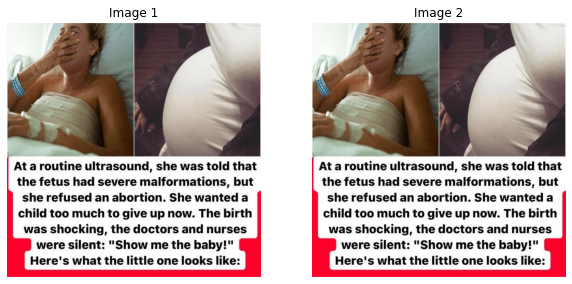

1/1 [==============================] - 0s 9ms/step
Similarity: 1


In [18]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """加载和预处理图像"""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

# 构建模型一次
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def calculate_similarity(image_path1, image_path2):
    """计算两张图片的相似度"""
    img1 = load_and_preprocess_image(image_path1)
    img2 = load_and_preprocess_image(image_path2)
    
    # 提取特征
    features1 = model.predict(img1).flatten()
    features2 = model.predict(img2).flatten()
    
    # 计算余弦相似度
    similarity = 1 - cosine(features1, features2)
    return similarity

# 使用示例
image_path1 = 'test/7.jpg'
image_path2 = 'test/8.jpg'

# 加载图片
img1 = load_img(image_path1)
img2 = load_img(image_path2)

# 创建一个图和两个子图
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # figsize控制总图大小

# 显示第一张图片
axs[0].imshow(img1)
axs[0].axis('off')  # 不显示坐标轴
axs[0].set_title('Image 1')

# 显示第二张图片
axs[1].imshow(img2)
axs[1].axis('off')  # 不显示坐标轴
axs[1].set_title('Image 2')

# 显示图像
plt.show()

similarity = calculate_similarity(image_path1, image_path2)
print(f"Similarity: {similarity}")


用VGG刪重複圖 (圖片多會超慢)

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """加载和预处理图像"""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

# 加载VGG16模型，并获取特征提取部分
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def calculate_features(directory):
    """计算目录中所有图片的特征，并存储为字典"""
    features = {}
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_array = load_and_preprocess_image(img_path)
            features[img_path] = model.predict(img_array).flatten()
    return features

def find_duplicates(features, threshold=1):
    """找出特征相似度高于阈值的重复图片"""
    duplicates = []
    keys = list(features.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            sim = 1 - cosine(features[keys[i]], features[keys[j]])
            if sim == threshold:
                duplicates.append(keys[j])
    return duplicates

def delete_duplicates(directory):
    """删除目录中的重复图片"""
    features = calculate_features(directory)
    duplicates = find_duplicates(features)
    for dup in duplicates:
        os.remove(dup)
        print(f"Deleted: {dup}")

# 指定图片所在的目录
directory = 'facebook/13940copy'
delete_duplicates(directory)


C:\Users\g11350025\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\g11350025\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Deleted: facebook/13940copy\244885258699709.jpg
Deleted: facebook/13940copy\302332662827149.jpg
Deleted: facebook/13940copy\358301250446146.jpg
Deleted: facebook/13940copy\390179863589444.jpg
Deleted: facebook/13940copy\403756752210565.jpg
Deleted: facebook/13940copy\406953018557976.jpg
Deleted: facebook/13940copy\417219887409039.jpg
Deleted: facebook/13940copy\223990464101518.jpg
Deleted: facebook/13940copy\270166456084052.jpg
Deleted: facebook/13940copy\313329571706360.jpg
Deleted: facebook/13940copy\314585291574627.jpg
Deleted: facebook/13940copy\315577908145572.jpg
Deleted: facebook/13940copy\321449214224990.jpg
Deleted: facebook/13940copy\322136644157604.jpg
Deleted: facebook/13940copy\368332759298521.jpg
Deleted: facebook/13940copy\380658914732572.jpg
Deleted: facebook/13940copy\381018464682612.jpg
Deleted: facebook/13940copy\383109557750116.jpg
Deleted: facebook/13940copy\393802833404175.jpg
Deleted: facebook/13940copy\39659736

FileNotFoundError: [WinError 2] 系統找不到指定的檔案。: 'facebook/13940copy\\270166456084052.jpg'

先用hash刪一些看起來幾乎一樣的

pip install Pillow imagehash

In [27]:
from PIL import Image
import imagehash
import os

def find_duplicates_with_phash(directory, hash_size=8):
    """使用感知哈希检查图片的视觉相似性"""
    hashes = {}
    duplicates = {}
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(directory, filename)
            img = Image.open(filepath)
            phash = imagehash.phash(img, hash_size)
            if phash in hashes:
                if phash not in duplicates:
                    duplicates[phash] = [hashes[phash]]
                duplicates[phash].append(filepath)
            else:
                hashes[phash] = filepath
    return duplicates


def delete_duplicates(duplicates):
    """删除重复的图片，只保留每组的第一张，且在用户确认后执行删除"""
    deleted_files = []
    for paths in duplicates.values():
        if len(paths) > 1:
            for path in paths[1:]:  # 保留第一张图片，等待用户确认后删除其余的图片
                print(f"Ready to delete: {path}")
    confirmation = input("Type 'ok' to confirm deletion: ")
    if confirmation.lower() == 'ok':
        for paths in duplicates.values():
            if len(paths) > 1:
                for path in paths[1:]:
                    os.remove(path)
                    deleted_files.append(path)
    return deleted_files

# 指定图片所在的目录
directory = 'reddit_all'
duplicates = find_duplicates_with_phash(directory)

# 输出所有视觉上相似的图片组
for key, paths in duplicates.items():
    if len(paths) > 1:
        print(f"Duplicate group based on perceptual hash {key}:")
        for path in paths:
            print(f"  {path}")

# 处理删除操作
deleted_files = delete_duplicates(duplicates)
if deleted_files:
    print(f"Deleted {len(deleted_files)} duplicate files:")
    for file in deleted_files:
        print(file)
    # 保存被删除文件的列表到文本文件
    with open('reddit_all/delet.txt', 'w') as file:
        for deleted_file in deleted_files:
            file.write(deleted_file + '\n')
else:
    print("No files were deleted.")

Duplicate group based on perceptual hash ee299e6fe091e0a1:
  reddit_all\8pyvu5l9w5v51 (2).jpg
  reddit_all\8pyvu5l9w5v51.jpg
Duplicate group based on perceptual hash 8edbd8f0f22dc051:
  reddit_all\7r7nc0p9wih61.jpg
  reddit_all\8zuamyqawih61.jpg
  reddit_all\mjdj3828wih61.jpg
Duplicate group based on perceptual hash bac1f51e6ae59089:
  reddit_all\2dmpbtgqm5a31.jpg
  reddit_all\antlxyutm5a31.jpg
Duplicate group based on perceptual hash eaad91e453683bc4:
  reddit_all\4t8qryy6m4531.jpg
  reddit_all\brgo8ouzk1531.jpg
Duplicate group based on perceptual hash b4a946ebb4da8994:
  reddit_all\4twam1hy19g51.png
  reddit_all\g6o9uvs98bg51.jpg
Duplicate group based on perceptual hash 8aa5ba55449b2f17:
  reddit_all\4d22uhndh46c1.jpeg
  reddit_all\g7vvqjdai46c1.jpeg
Duplicate group based on perceptual hash a6efc6805f047ab1:
  reddit_all\2828ephb8ipc1.jpeg
  reddit_all\gypunvmok48a1.jpg
Duplicate group based on perceptual hash e91b4a3e6912d2ec:
  reddit_all\h1ftum9txls41.jpg
  reddit_all\hoprcgkoxls4

再刪只有文字沒有圖像的圖片 (迷因字比較大的話會刪到迷因)

In [10]:
import os
import easyocr
from PIL import Image

def calculate_text_area_proportion(image_path):
    """计算图片中文本区域占图片总面积的比例"""
    reader = easyocr.Reader(['en'], gpu=False)  # 假设图片中的文字是英文
    results = reader.readtext(image_path)
    
    img = Image.open(image_path)
    img_width, img_height = img.size
    img_area = img_width * img_height

    text_area = 0
    for result in results:
        top_left = result[0][0]
        bottom_right = result[0][2]
        # 计算每个文本框的面积
        text_width = bottom_right[0] - top_left[0]
        text_height = bottom_right[1] - top_left[1]
        text_area += text_width * text_height

    # 计算文本区域占图片总面积的比例
    text_area_proportion = (text_area / img_area) * 100
    return text_area_proportion

def output_text_area_proportions(directory):
    """输出目录中所有图片的文本区域占比"""
    text_area_proportions = {}
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg')):
            proportion = calculate_text_area_proportion(filepath)
            text_area_proportions[filename] = proportion
    return text_area_proportions

# 指定图片所在的目录
directory = 'test/t2'
proportions = output_text_area_proportions(directory)
for filename, proportion in proportions.items():
    print(f"{filename}: {proportion:.2f}% text area")


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.


1.jpg: 26.78% text area
2.jpg: 15.38% text area
216287018225831.jpg: 38.96% text area
3.jpg: 7.13% text area
4.jpg: 59.46% text area
414520710963247.jpg: 47.84% text area
414702041069793.jpg: 25.12% text area
415155527561787.jpg: 29.41% text area
415221547679814.jpg: 33.95% text area
5.jpg: 13.63% text area
6.jpg: 11.12% text area


### 完整流程 ###

1. 複製子目錄下所有圖片(jpg png jpeg)集中到一個資料夾，以原資料夾位置做檔名前綴用底線隔開\
e.g. reddit_antimeme_Abort_0eohs2f78se21.jpg

In [31]:
import os
import shutil

def copy_images(source_directory, target_directory):
    # 创建目标目录如果它不存在
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # 遍历源目录和所有子目录
    for dirpath, dirnames, filenames in os.walk(source_directory):
        for filename in filenames:
            # 检查文件是否是图片
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                # 构建完整的文件路径
                file_path = os.path.join(dirpath, filename)
                # 构建唯一文件名，包括其源子目录信息
                relative_path = os.path.relpath(dirpath, source_directory)
                unique_filename = f"{relative_path.replace(os.sep, '_')}_{filename}"  # 将目录分隔符替换为下划线
                # 构建目标文件路径
                target_path = os.path.join(target_directory, unique_filename)
                # 复制文件
                shutil.copy(file_path, target_path)
                print(f'Copied "{file_path}" to "{target_path}"')

# 使用示例
source_directory = 'reddit'  # 源目录路径
target_directory = 'redditall/reddit'  # 目标目录路径

copy_images(source_directory, target_directory)


Copied "reddit\reddit_antimeme\Abort\09cg170yklk91.jpg" to "redditall/reddit\reddit_antimeme_Abort_09cg170yklk91.jpg"
Copied "reddit\reddit_antimeme\Abort\0eohs2f78se21.jpg" to "redditall/reddit\reddit_antimeme_Abort_0eohs2f78se21.jpg"
Copied "reddit\reddit_antimeme\Abort\0fpr1emytcx21.jpg" to "redditall/reddit\reddit_antimeme_Abort_0fpr1emytcx21.jpg"
Copied "reddit\reddit_antimeme\Abort\0g4tndwcwid51.jpg" to "redditall/reddit\reddit_antimeme_Abort_0g4tndwcwid51.jpg"
Copied "reddit\reddit_antimeme\Abort\0kavx3o13xd61.jpg" to "redditall/reddit\reddit_antimeme_Abort_0kavx3o13xd61.jpg"
Copied "reddit\reddit_antimeme\Abort\1drmcjw1g5n51.png" to "redditall/reddit\reddit_antimeme_Abort_1drmcjw1g5n51.png"
Copied "reddit\reddit_antimeme\Abort\1leg1auqun221.jpg" to "redditall/reddit\reddit_antimeme_Abort_1leg1auqun221.jpg"
Copied "reddit\reddit_antimeme\Abort\1lttnj4lgra11.png" to "redditall/reddit\reddit_antimeme_Abort_1lttnj4lgra11.png"
Copied "reddit\reddit_antimeme\Abort\1p1pqwowcxi01.jpg" 

Copied "reddit\reddit_dankmemes\Abort\ehzlazmvotn31.jpg" to "redditall/reddit\reddit_dankmemes_Abort_ehzlazmvotn31.jpg"
Copied "reddit\reddit_dankmemes\Abort\f72hdf47hfg21.png" to "redditall/reddit\reddit_dankmemes_Abort_f72hdf47hfg21.png"
Copied "reddit\reddit_dankmemes\Abort\fb7othrl01s21.jpg" to "redditall/reddit\reddit_dankmemes_Abort_fb7othrl01s21.jpg"
Copied "reddit\reddit_dankmemes\Abort\fone4kx1a3y61.jpg" to "redditall/reddit\reddit_dankmemes_Abort_fone4kx1a3y61.jpg"
Copied "reddit\reddit_dankmemes\Abort\fp6e4rtw7uk31.jpg" to "redditall/reddit\reddit_dankmemes_Abort_fp6e4rtw7uk31.jpg"
Copied "reddit\reddit_dankmemes\Abort\fpdoudyfjhc31.jpg" to "redditall/reddit\reddit_dankmemes_Abort_fpdoudyfjhc31.jpg"
Copied "reddit\reddit_dankmemes\Abort\g45e51dtqnb51.png" to "redditall/reddit\reddit_dankmemes_Abort_g45e51dtqnb51.png"
Copied "reddit\reddit_dankmemes\Abort\gjmfz5ouwj431.jpg" to "redditall/reddit\reddit_dankmemes_Abort_gjmfz5ouwj431.jpg"
Copied "reddit\reddit_dankmemes\Abort\gk

Copied "reddit\reddit_dankmemes\post-abortion\b8mzr1uv9p791.jpg" to "redditall/reddit\reddit_dankmemes_post-abortion_b8mzr1uv9p791.jpg"
Copied "reddit\reddit_dankmemes\post-abortion\cfxg3u5o76ky.jpg" to "redditall/reddit\reddit_dankmemes_post-abortion_cfxg3u5o76ky.jpg"
Copied "reddit\reddit_dankmemes\post-abortion\cggg2g2aaal41.jpg" to "redditall/reddit\reddit_dankmemes_post-abortion_cggg2g2aaal41.jpg"
Copied "reddit\reddit_dankmemes\post-abortion\co1a6wsoqkv81.png" to "redditall/reddit\reddit_dankmemes_post-abortion_co1a6wsoqkv81.png"
Copied "reddit\reddit_dankmemes\post-abortion\d0lwxlml7sx21.png" to "redditall/reddit\reddit_dankmemes_post-abortion_d0lwxlml7sx21.png"
Copied "reddit\reddit_dankmemes\post-abortion\d8ygckh4k3h41.jpg" to "redditall/reddit\reddit_dankmemes_post-abortion_d8ygckh4k3h41.jpg"
Copied "reddit\reddit_dankmemes\post-abortion\dpoy8ao7v3a91.jpg" to "redditall/reddit\reddit_dankmemes_post-abortion_dpoy8ao7v3a91.jpg"
Copied "reddit\reddit_dankmemes\post-abortion\e755

Copied "reddit\reddit_meme\abortion\bzsubg8e1ew61.jpg" to "redditall/reddit\reddit_meme_abortion_bzsubg8e1ew61.jpg"
Copied "reddit\reddit_meme\abortion\cior064x19o71.jpg" to "redditall/reddit\reddit_meme_abortion_cior064x19o71.jpg"
Copied "reddit\reddit_meme\abortion\conu3addrpw61.jpg" to "redditall/reddit\reddit_meme_abortion_conu3addrpw61.jpg"
Copied "reddit\reddit_meme\abortion\cwbq928s3e9b1.png" to "redditall/reddit\reddit_meme_abortion_cwbq928s3e9b1.png"
Copied "reddit\reddit_meme\abortion\czw6pxzllmec1.jpeg" to "redditall/reddit\reddit_meme_abortion_czw6pxzllmec1.jpeg"
Copied "reddit\reddit_meme\abortion\d8dxlo6scgla1.png" to "redditall/reddit\reddit_meme_abortion_d8dxlo6scgla1.png"
Copied "reddit\reddit_meme\abortion\ddl5rvc7w5151.png" to "redditall/reddit\reddit_meme_abortion_ddl5rvc7w5151.png"
Copied "reddit\reddit_meme\abortion\dtkika3rv0851.jpg" to "redditall/reddit\reddit_meme_abortion_dtkika3rv0851.jpg"
Copied "reddit\reddit_meme\abortion\dyohsyjbfik41.jpg" to "redditall/r

Copied "reddit\reddit_memes\abortion\2lverrd3vbf51.jpg" to "redditall/reddit\reddit_memes_abortion_2lverrd3vbf51.jpg"
Copied "reddit\reddit_memes\abortion\2w2ayktlins71.jpg" to "redditall/reddit\reddit_memes_abortion_2w2ayktlins71.jpg"
Copied "reddit\reddit_memes\abortion\3q8xjqisbh241.jpg" to "redditall/reddit\reddit_memes_abortion_3q8xjqisbh241.jpg"
Copied "reddit\reddit_memes\abortion\3v0q12bpcfb21.jpg" to "redditall/reddit\reddit_memes_abortion_3v0q12bpcfb21.jpg"
Copied "reddit\reddit_memes\abortion\3z9b2dshrsn41.jpg" to "redditall/reddit\reddit_memes_abortion_3z9b2dshrsn41.jpg"
Copied "reddit\reddit_memes\abortion\45kd1y5mi6d41.jpg" to "redditall/reddit\reddit_memes_abortion_45kd1y5mi6d41.jpg"
Copied "reddit\reddit_memes\abortion\460ncec7hiu51.jpg" to "redditall/reddit\reddit_memes_abortion_460ncec7hiu51.jpg"
Copied "reddit\reddit_memes\abortion\47tozngpxxe51.png" to "redditall/reddit\reddit_memes_abortion_47tozngpxxe51.png"
Copied "reddit\reddit_memes\abortion\4clh7ah4llt71.jpg" 

Copied "reddit\reddit_memes\prolife\ye40f0tys0891.jpg" to "redditall/reddit\reddit_memes_prolife_ye40f0tys0891.jpg"
Copied "reddit\reddit_memes\prolife\zafjs1pd7s2b1.jpg" to "redditall/reddit\reddit_memes_prolife_zafjs1pd7s2b1.jpg"
Copied "reddit\reddit_memes\right-to-life\0o7s0a476vg61.jpg" to "redditall/reddit\reddit_memes_right-to-life_0o7s0a476vg61.jpg"
Copied "reddit\reddit_memes\right-to-life\13g52uonjgf41.png" to "redditall/reddit\reddit_memes_right-to-life_13g52uonjgf41.png"
Copied "reddit\reddit_memes\right-to-life\1sg108b9h3a61.jpg" to "redditall/reddit\reddit_memes_right-to-life_1sg108b9h3a61.jpg"
Copied "reddit\reddit_memes\right-to-life\2ib84g8i01a61.png" to "redditall/reddit\reddit_memes_right-to-life_2ib84g8i01a61.png"
Copied "reddit\reddit_memes\right-to-life\3kkjtmymp2p91.jpg" to "redditall/reddit\reddit_memes_right-to-life_3kkjtmymp2p91.jpg"
Copied "reddit\reddit_memes\right-to-life\3l50yfzykz9z.jpg" to "redditall/reddit\reddit_memes_right-to-life_3l50yfzykz9z.jpg"
Co

Copied "reddit\reddit_politicalmemes\abortion\fsuagd9dhbl71.jpg" to "redditall/reddit\reddit_politicalmemes_abortion_fsuagd9dhbl71.jpg"
Copied "reddit\reddit_politicalmemes\abortion\fsx4wm41hhec1.jpeg" to "redditall/reddit\reddit_politicalmemes_abortion_fsx4wm41hhec1.jpeg"
Copied "reddit\reddit_politicalmemes\abortion\fzaor48d5x8c1.jpeg" to "redditall/reddit\reddit_politicalmemes_abortion_fzaor48d5x8c1.jpeg"
Copied "reddit\reddit_politicalmemes\abortion\g039pm8wwdmc1.jpeg" to "redditall/reddit\reddit_politicalmemes_abortion_g039pm8wwdmc1.jpeg"
Copied "reddit\reddit_politicalmemes\abortion\g7vvqjdai46c1.jpeg" to "redditall/reddit\reddit_politicalmemes_abortion_g7vvqjdai46c1.jpeg"
Copied "reddit\reddit_politicalmemes\abortion\g92brq6bhnm71.jpg" to "redditall/reddit\reddit_politicalmemes_abortion_g92brq6bhnm71.jpg"
Copied "reddit\reddit_politicalmemes\abortion\gu77kqp49s5c1.png" to "redditall/reddit\reddit_politicalmemes_abortion_gu77kqp49s5c1.png"
Copied "reddit\reddit_politicalmemes\abo

2. 把資料夾的裡的所有子目錄的csv集合成一個 並在最後新增每筆資料來源自哪個csv檔(csv檔的物件名稱)\
注意 根目錄 跟儲存 csv目錄

In [32]:
import pandas as pd
import os

def merge_csv_files(root_directory):
    all_data = []
    for subdir, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith('.csv') and file != 'error.csv':  # 排除名为 error.csv 的文件
                file_path = os.path.join(subdir, file)
                # 检查文件是否为空
                if os.stat(file_path).st_size > 0:  # 检查文件大小是否大于0
                    df = pd.read_csv(file_path)
                    if not df.empty:  # 检查 DataFrame 是否为空
                        df['Source CSV Path'] = file_path  # 存储完整的文件路径
                        all_data.append(df)
                else:
                    print(f"Skipped empty file: {file_path}")  # 打印空文件被跳过的消息

    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv('redditall/combined_data.csv', index=False)

# 调用函数，输入你的根目录
merge_csv_files('reddit')


3. 整理csv的亂資料\
csv檔只留下URL欄位以.png .jpg .jpeg .gif結尾的資料

In [36]:
import pandas as pd

# 讀取 CSV 檔案
df = pd.read_csv('redditall/combined_data.csv')

# 假設 URL 欄位名稱為 'url_column'
# 過濾出 URL 以 .png, .jpg, .jpeg, .gif 結尾的資料
filtered_df = df[df['URL'].str.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

# 將過濾後的資料存儲到新的 CSV 檔案
filtered_df.to_csv('redditall/combined_data.csv', index=False)


4. 用hash刪一些看起來幾乎一樣的，並用txt紀錄刪除的圖片

In [39]:
from PIL import Image
import imagehash
import os

def find_duplicates_with_phash(directory, hash_size=8):
    """使用感知哈希检查图片的视觉相似性"""
    hashes = {}
    duplicates = {}
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(directory, filename)
            img = Image.open(filepath)
            phash = imagehash.phash(img, hash_size)
            if phash in hashes:
                if phash not in duplicates:
                    duplicates[phash] = [hashes[phash]]
                duplicates[phash].append(filepath)
            else:
                hashes[phash] = filepath
    return duplicates


def delete_duplicates(duplicates):
    """删除重复的图片，只保留每组的第一张，且在用户确认后执行删除"""
    deleted_files = []
    for paths in duplicates.values():
        if len(paths) > 1:
            for path in paths[1:]:  # 保留第一张图片，等待用户确认后删除其余的图片
                print(f"Ready to delete: {path}")
    confirmation = input("Type 'ok' to confirm deletion: ")
    if confirmation.lower() == 'ok':
        for paths in duplicates.values():
            if len(paths) > 1:
                for path in paths[1:]:
                    os.remove(path)
                    deleted_files.append(path)
    return deleted_files

# 指定图片所在的目录
directory = 'redditall/reddit'
duplicates = find_duplicates_with_phash(directory)

# 输出所有视觉上相似的图片组
for key, paths in duplicates.items():
    if len(paths) > 1:
        print(f"Duplicate group based on perceptual hash {key}:")
        for path in paths:
            print(f"  {path}")

# 处理删除操作
deleted_files = delete_duplicates(duplicates)
if deleted_files:
    print(f"Deleted {len(deleted_files)} duplicate files:")
    for file in deleted_files:
        print(file)
    # 保存被删除文件的列表到文本文件
    with open('redditall/delet.txt', 'w') as file:
        for deleted_file in deleted_files:
            file.write(deleted_file + '\n')
else:
    print("No files were deleted.")

Duplicate group based on perceptual hash bc2cc3931f69e42c:
  redditall/reddit\reddit_antimeme_abortion_09cg170yklk91.jpg
  redditall/reddit\reddit_antimeme_Abort_09cg170yklk91.jpg
Duplicate group based on perceptual hash e7999294d1aa5176:
  redditall/reddit\reddit_antimeme_abortion_8x3udmf7qjz71.jpg
  redditall/reddit\reddit_antimeme_Abort_8x3udmf7qjz71.jpg
Duplicate group based on perceptual hash 8f0eb0fbc5b0b01e:
  redditall/reddit\reddit_antimeme_abortion_8xs9qmmmwrza1.jpg
  redditall/reddit\reddit_antimeme_Abort_8xs9qmmmwrza1.jpg
Duplicate group based on perceptual hash ce9bb9d4a40ca4d9:
  redditall/reddit\reddit_antimeme_abortion_adoxxvsf63q31.jpg
  redditall/reddit\reddit_antimeme_Abort_adoxxvsf63q31.jpg
Duplicate group based on perceptual hash 9ea9d6a4591e6619:
  redditall/reddit\reddit_antimeme_abortion_agonmy9qz8k41.png
  redditall/reddit\reddit_antimeme_Abort_agonmy9qz8k41.png
Duplicate group based on perceptual hash e9b4e91e9ac83469:
  redditall/reddit\reddit_antimeme_aborti

Ready to delete: redditall/reddit\reddit_politicalmemes_post-abortion_kapc35fpso591.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_kbi4yerdowx81.png
Ready to delete: redditall/reddit\reddit_politicalmemes_pro abortion_kbi4yerdowx81.png
Ready to delete: redditall/reddit\reddit_politicalmemes_pro-abortion_kbi4yerdowx81.png
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_lfaugohg5z281.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_lqgqpvpokdcb1.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_post-abortion_lqgqpvpokdcb1.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_mb54xdg75q8a1.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_mwcdadez2vz91.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_n51lf4crx4aa1.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_anti-choice_n51lf4crx4aa1.jpg
Ready to delete: redditall/reddit\reddit_politicalmemes_Abort_n965y5ou8m4b1.png
Read

Type 'ok' to confirm deletion: ok
Deleted 1069 duplicate files:
redditall/reddit\reddit_antimeme_Abort_09cg170yklk91.jpg
redditall/reddit\reddit_antimeme_Abort_8x3udmf7qjz71.jpg
redditall/reddit\reddit_antimeme_Abort_8xs9qmmmwrza1.jpg
redditall/reddit\reddit_antimeme_Abort_adoxxvsf63q31.jpg
redditall/reddit\reddit_antimeme_Abort_agonmy9qz8k41.png
redditall/reddit\reddit_antimeme_Abort_dy87flw7zgy31.jpg
redditall/reddit\reddit_antimeme_Abort_lem2c0xd3h841.jpg
redditall/reddit\reddit_antimeme_Abort_o1e2kkn9woe91.jpg
redditall/reddit\reddit_antimeme_Abort_omqh6loefxa21.jpg
redditall/reddit\reddit_dankmemes_abortion_cjg85351b3f31.jpg
redditall/reddit\reddit_dankmemes_abortion_omqh6loefxa21.jpg
redditall/reddit\reddit_dankmemes_Abort_cjg85351b3f31.jpg
redditall/reddit\reddit_dankmemes_Abort_omqh6loefxa21.jpg
redditall/reddit\reddit_antimeme_Abort_wrgvyqft8o461.jpg
redditall/reddit\reddit_dankmemes_abortion_0eohs2f78se21.jpg
redditall/reddit\reddit_dankmemes_Abort_0eohs2f78se21.jpg
redditall

第四步結果：剩餘 1293 張圖片

5. 資料夾的所有圖片用GPT摘要兩句話，個別存成txt

In [ ]:
#資料夾的所有圖片用GPT摘要兩句話，個別存成txt
import os
import base64
import openai

# 读取图片并转为base64编码
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        encoded_string = base64.b64encode(img_file.read()).decode("utf-8")
    return encoded_string

# 描述图片
def describe_image(image_path):
    base64_image = image_to_base64(image_path)
    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        temperature=0,
        messages=[
#             {"role": "assistant", "content": "請根據問題分別使用繁體中文和英文回覆"},
            {
                "role": "user",
                "content": [
                    {"type": "text", 
                     "text": "這是一張可能與墮胎相關的迷因，用兩句話解釋這張迷因"},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{base64_image}"}
                    },
                ],
            }
        ],
        max_tokens=300,
    )
    return response.choices[0].message.content

# 图片文件夹路径
folder_path = "redditall/reddit"
# 遍历文件夹中的所有jpg图片
for filename in os.listdir(folder_path):
    try:
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            description = describe_image(image_path)
            print(description)

            # 将描述保存到文本文件
            output_path = image_path.split('.')[0] + '.txt'
            with open(output_path, 'w', encoding='utf-8') as f:
                f.write(description)
    except Exception as e:
        print(e)
        


6. 手動分類\
顯示 圖片ID、文章標題、GPT API寫的兩句摘要、圖片，輸入分類編號點下ok會自動換下一張圖片，每分類完一張圖片就會存成csv檔，檔案裡有三個欄位：圖片ID、圖片路徑位置、分類編號，最後分類完所有圖片，得到一個有所有圖片的csv檔

In [44]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog, simpledialog, Label, Button
from PIL import Image, ImageTk
import os

class ImageReviewer(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title('图像评论工具')
        self.label = Label(self, text='点击“打开”开始评论图像。')
        self.label.pack(pady=20)
        
        self.open_button = Button(self, text='打开文件夹', command=self.open_directory)
        self.open_button.pack(pady=10)
        
        self.image_name_label = Label(self, text='', font=('Arial', 14))
        self.image_name_label.pack(pady=5)
        
        self.title_label = Label(self, text='', wraplength=400)
        self.title_label.pack(pady=5)
        
        self.article_label = Label(self, text='', wraplength=400)
        self.article_label.pack(pady=5)
        
        self.image_label = Label(self)
        self.image_label.pack(pady=10)
        
        self.data = pd.DataFrame(columns=['Image ID', 'File Path', 'User Input'])

    def load_articles(self):
        self.articles = pd.read_csv('redditall/combined_data.csv')

    def open_directory(self):
        directory = filedialog.askdirectory()
        self.images = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.png','.jpeg'))]
        self.images.sort() #按文件名排序
        self.load_articles()
        self.image_index = 0
        self.show_image()
        
    def show_image(self):
        if self.image_index < len(self.images):
            img_path = self.images[self.image_index]
            img_name, _ = os.path.splitext(os.path.basename(img_path))
            
            # 使用 '_' 分割 img_name 并获取最后一部分
            img_name = img_name.split('_')[-1]
        
            self.image_name_label.config(text=f"图片名称: {img_name}")  # 显示图片名称
            
            img = Image.open(img_path)
            img = img.resize((400, 400), Image.Resampling.LANCZOS)
            photo_img = ImageTk.PhotoImage(img)
            self.image_label.config(image=photo_img)
            self.image_label.image = photo_img  # 保留引用!
            
            mask = self.articles['URL'].str.contains(img_name, case=False, na=False)
            if mask.any():
                article_title = self.articles.loc[mask, 'Title'].values[0]
            else:
                article_title = "无相关文章标题"
            
            try:
                with open(os.path.join(os.path.dirname(img_path), img_name + '.txt'), 'r', encoding='utf-8') as file:
                    article_content = file.read()
            except FileNotFoundError:
                article_content = "未找到相关文本文件"
                print(f"未找到 {img_name}.txt 文件。")
                
            self.title_label.config(text=article_title)
            self.article_label.config(text=article_content)
            
            user_input = simpledialog.askstring("输入", "请输入您的评论:")
            new_row = pd.DataFrame([[img_name, img_path, user_input]], columns=['Image ID', 'File Path', 'User Input'])
            self.data = pd.concat([self.data, new_row], ignore_index=True)
            self.data.to_csv('redditall/classification.csv', index=False)
            
            print(f"Image ID: {img_name}, Comment: {user_input}")  # 打印图像 ID 和评论
            
            self.image_index += 1
            if self.image_index < len(self.images):
                self.after(1000, self.show_image)  # 推迟下一张图片的显示
            else:
                self.label.config(text='所有图像评论完成。数据已保存。')

app = ImageReviewer()
app.mainloop()

未找到 100pjnw8n4651.txt 文件。


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1889, in __call__
    try:
KeyboardInterrupt


Image ID: 100pjnw8n4651, Comment: None
